In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2

import os
from random import sample
from tqdm import tqdm

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in /home/zeinovich/.cache/torch/hub/pytorch_vision_v0.10.0
/home/zeinovich/anaconda3/envs/image-ranking/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeinovich/anaconda3/envs/image-ranking/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
model = model.features

In [6]:
model

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [7]:
# make torch tensors from images

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
])


In [8]:
import shutil

if len(os.listdir('../data/sample/0')) == 0:
    images = os.listdir('../data/images')
    images = sample(images, 10000)
    for image in images:
        shutil.copyfile(f'../data/images/{image}', f'../data/sample/0/{image}')

else:
    images = os.listdir('../data/sample/0')


In [9]:
imfolder = ImageFolder('../data/sample', transform=transform)

In [10]:
data_loader = DataLoader(imfolder, batch_size=1, shuffle=False)

In [11]:
# make np.array of features

features = []

for i, (x, _) in tqdm(enumerate(data_loader), total=len(data_loader)):

    with torch.no_grad():
        y = model(x)
        y = y.numpy()
        features.append(y)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/zeinovich/anaconda3/envs/image-ranking/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  2%|▏         | 155/10000 [00:09<09:44, 16.83it/s]


KeyboardInterrupt: 

In [ ]:
features = np.concatenate(features, axis=0)

In [ ]:
features.shape

(1000, 1280, 7, 7)

In [ ]:
features = features.reshape(features.shape[0], -1)

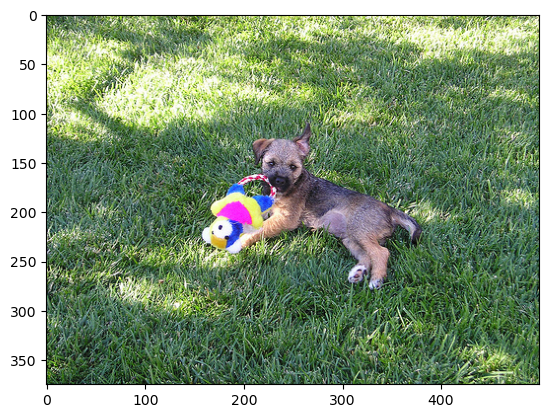

[[ 18 520 252 313 557]]
ILSVRC2012_val_00002763.JPEG


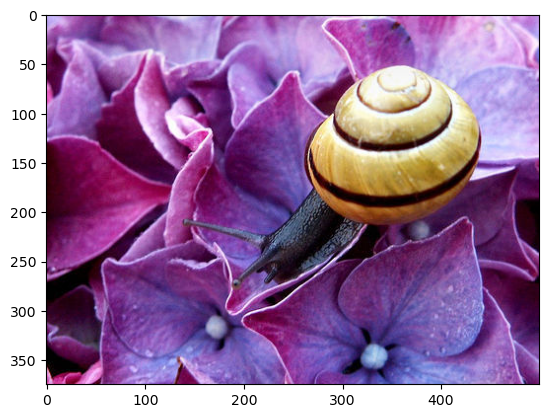

ILSVRC2012_val_00044454.JPEG


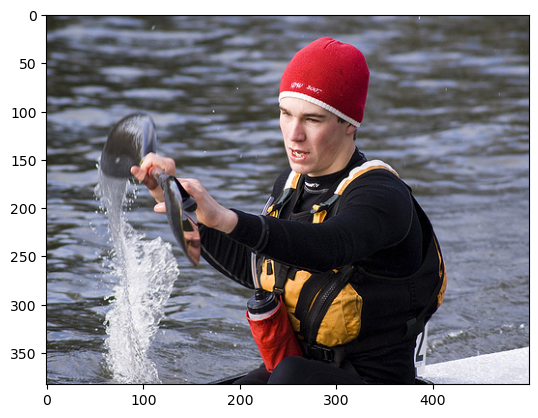

ILSVRC2012_val_00038431.JPEG


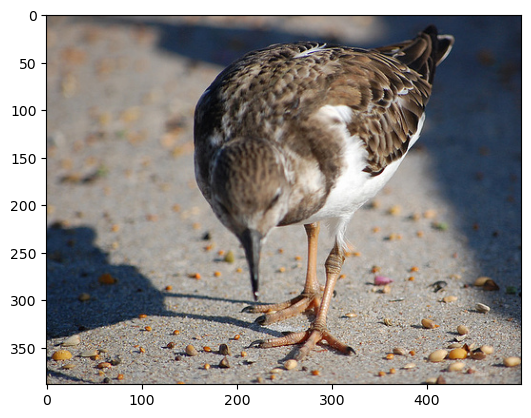

ILSVRC2012_val_00046018.JPEG


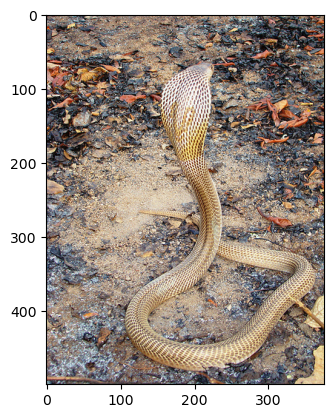

In [ ]:
# use approximate nearest neighbors to find similar images

from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, metric='cosine')
nn.fit(features)

# find similar images
i = 18

image = images[i]
image_path = f'../data/images/{image}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
distances, indices = nn.kneighbors(features[i].reshape(1, -1))
print(indices)

for j, index in enumerate(indices[0]):
    if j == 0:
        continue
    image = images[index]
    print(image)
    image_path = f'../data/images/{image}'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()